### Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

### Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

### И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

# Проект: классификация

In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [391]:
df = pd.read_csv('../../data/bank_fin.csv', sep = ';')

In [392]:
print('Сумма пропусков {}' .format (sum(df.isnull().sum())))
df.isnull().sum()

# balance
# 25

Сумма пропусков 25


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [393]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

# unknown

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [394]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance']=df['balance'].apply(lambda x: float(str(x).replace('$','').replace(' ','').replace(',','.')))
print(f'Количество пропусков {df['balance'].isnull().sum()}')
df['balance']

print('среднее значение по преобразованному = {:.3f}'.format(df['balance'].mean()))

Количество пропусков 25
среднее значение по преобразованному = 1529.129


In [395]:
# def replace_str(x):
#     if not x is None:
#         return float(str(x).replace('$','').replace(' ','').replace(',','.'))
#     return x

# # df['balance']=df['balance'].apply(replace_str)

### Задание 4

In [396]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
# values = {
#     'balance' : df['balance'].median()
#          }
# df = df.fillna(values)

df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()
print(f'Количество пропусков {df['balance'].isnull().sum()}')

print('среднее значение по преобразованному = {:.3f}'.format(df['balance'].mean()))

Количество пропусков 0
среднее значение по преобразованному = 1526.936


### Задание 5

In [397]:
# # обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.loc[(df['job']=='unknown'),'job']=df['job'].mode()[0]
df.loc[(df['education']=='unknown'),'education']=df['education'].mode()[0]
# display(df['job'].value_counts())
# display(df['education'].value_counts())
print('среднее значение по преобразованному = {:.3f}'.format(df[(df['job']==df['job'].mode()[0])&(df['education']==df['education'].mode()[0])]['balance'].mean()))

среднее значение по преобразованному = 1598.883


### Задание 6

Нижняя граница: -2241
Верхняя граница: 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


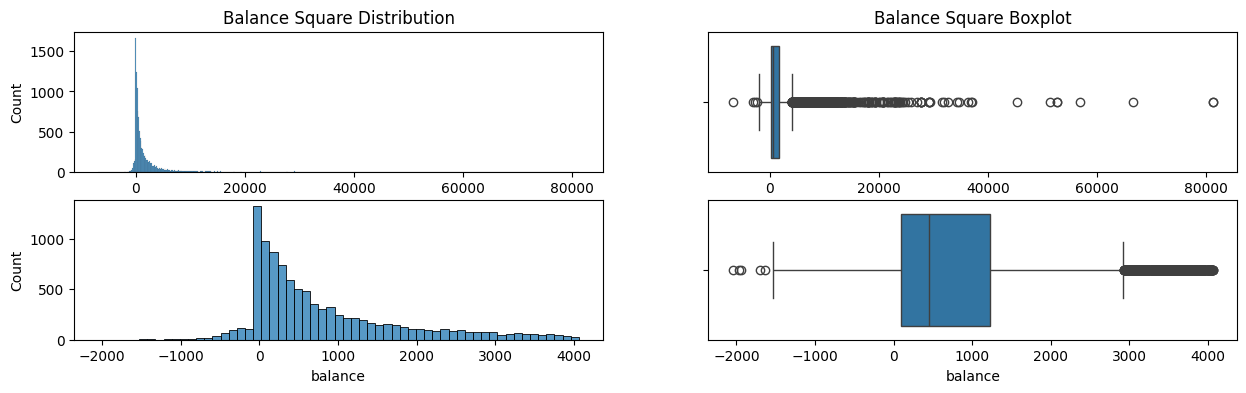

In [398]:
# удалите все выбросы для признака balance
# plt.figure()
# pl=sns.boxplot( x=df["balance"])
# plt.show()

def outliers_iqr_mod(data, feature, left = 1.5, right = 1.5, log_scale = False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    print('Нижняя граница: {:.0f}'.format(lower_bound))
    print('Верхняя граница: {:.0f}'.format(upper_bound))
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0][0]);
histplot.set_title('Balance Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[0][1]);
boxplot.set_title('Balance Square Boxplot');

outliers, df_cleaned = outliers_iqr_mod(df, 'balance')#, left = 1, right= 2)#, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_cleaned.shape[0]}')

histplot = sns.histplot(data=df_cleaned, x='balance', ax=axes[1][0]);
boxplot = sns.boxplot(data=df_cleaned, x='balance', ax=axes[1][1]);

## Часть 2:  Разведывательный анализ

### Задание 1

Сколько клиентов открыли депозит: 4681


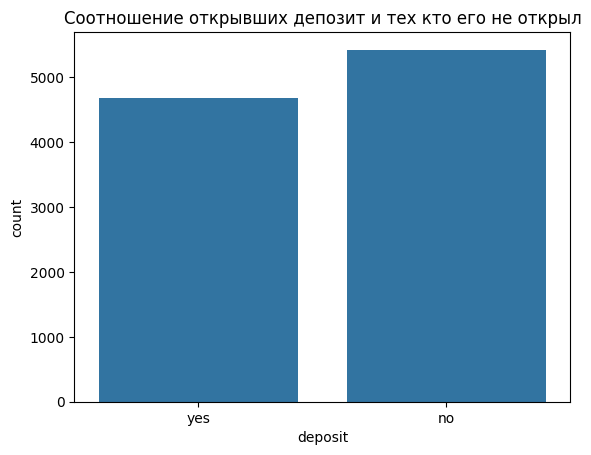

In [399]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df_cleaned, x='deposit').set_title('Соотношение открывших депозит и тех кто его не открыл')

print(f'Сколько клиентов открыли депозит: {df_cleaned[df_cleaned['deposit']=='yes']['deposit'].count()}')

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


максимальный возраст клиента банка 95
минимальная продолжительность разговора с клиентом банка 2


<Figure size 640x480 with 0 Axes>

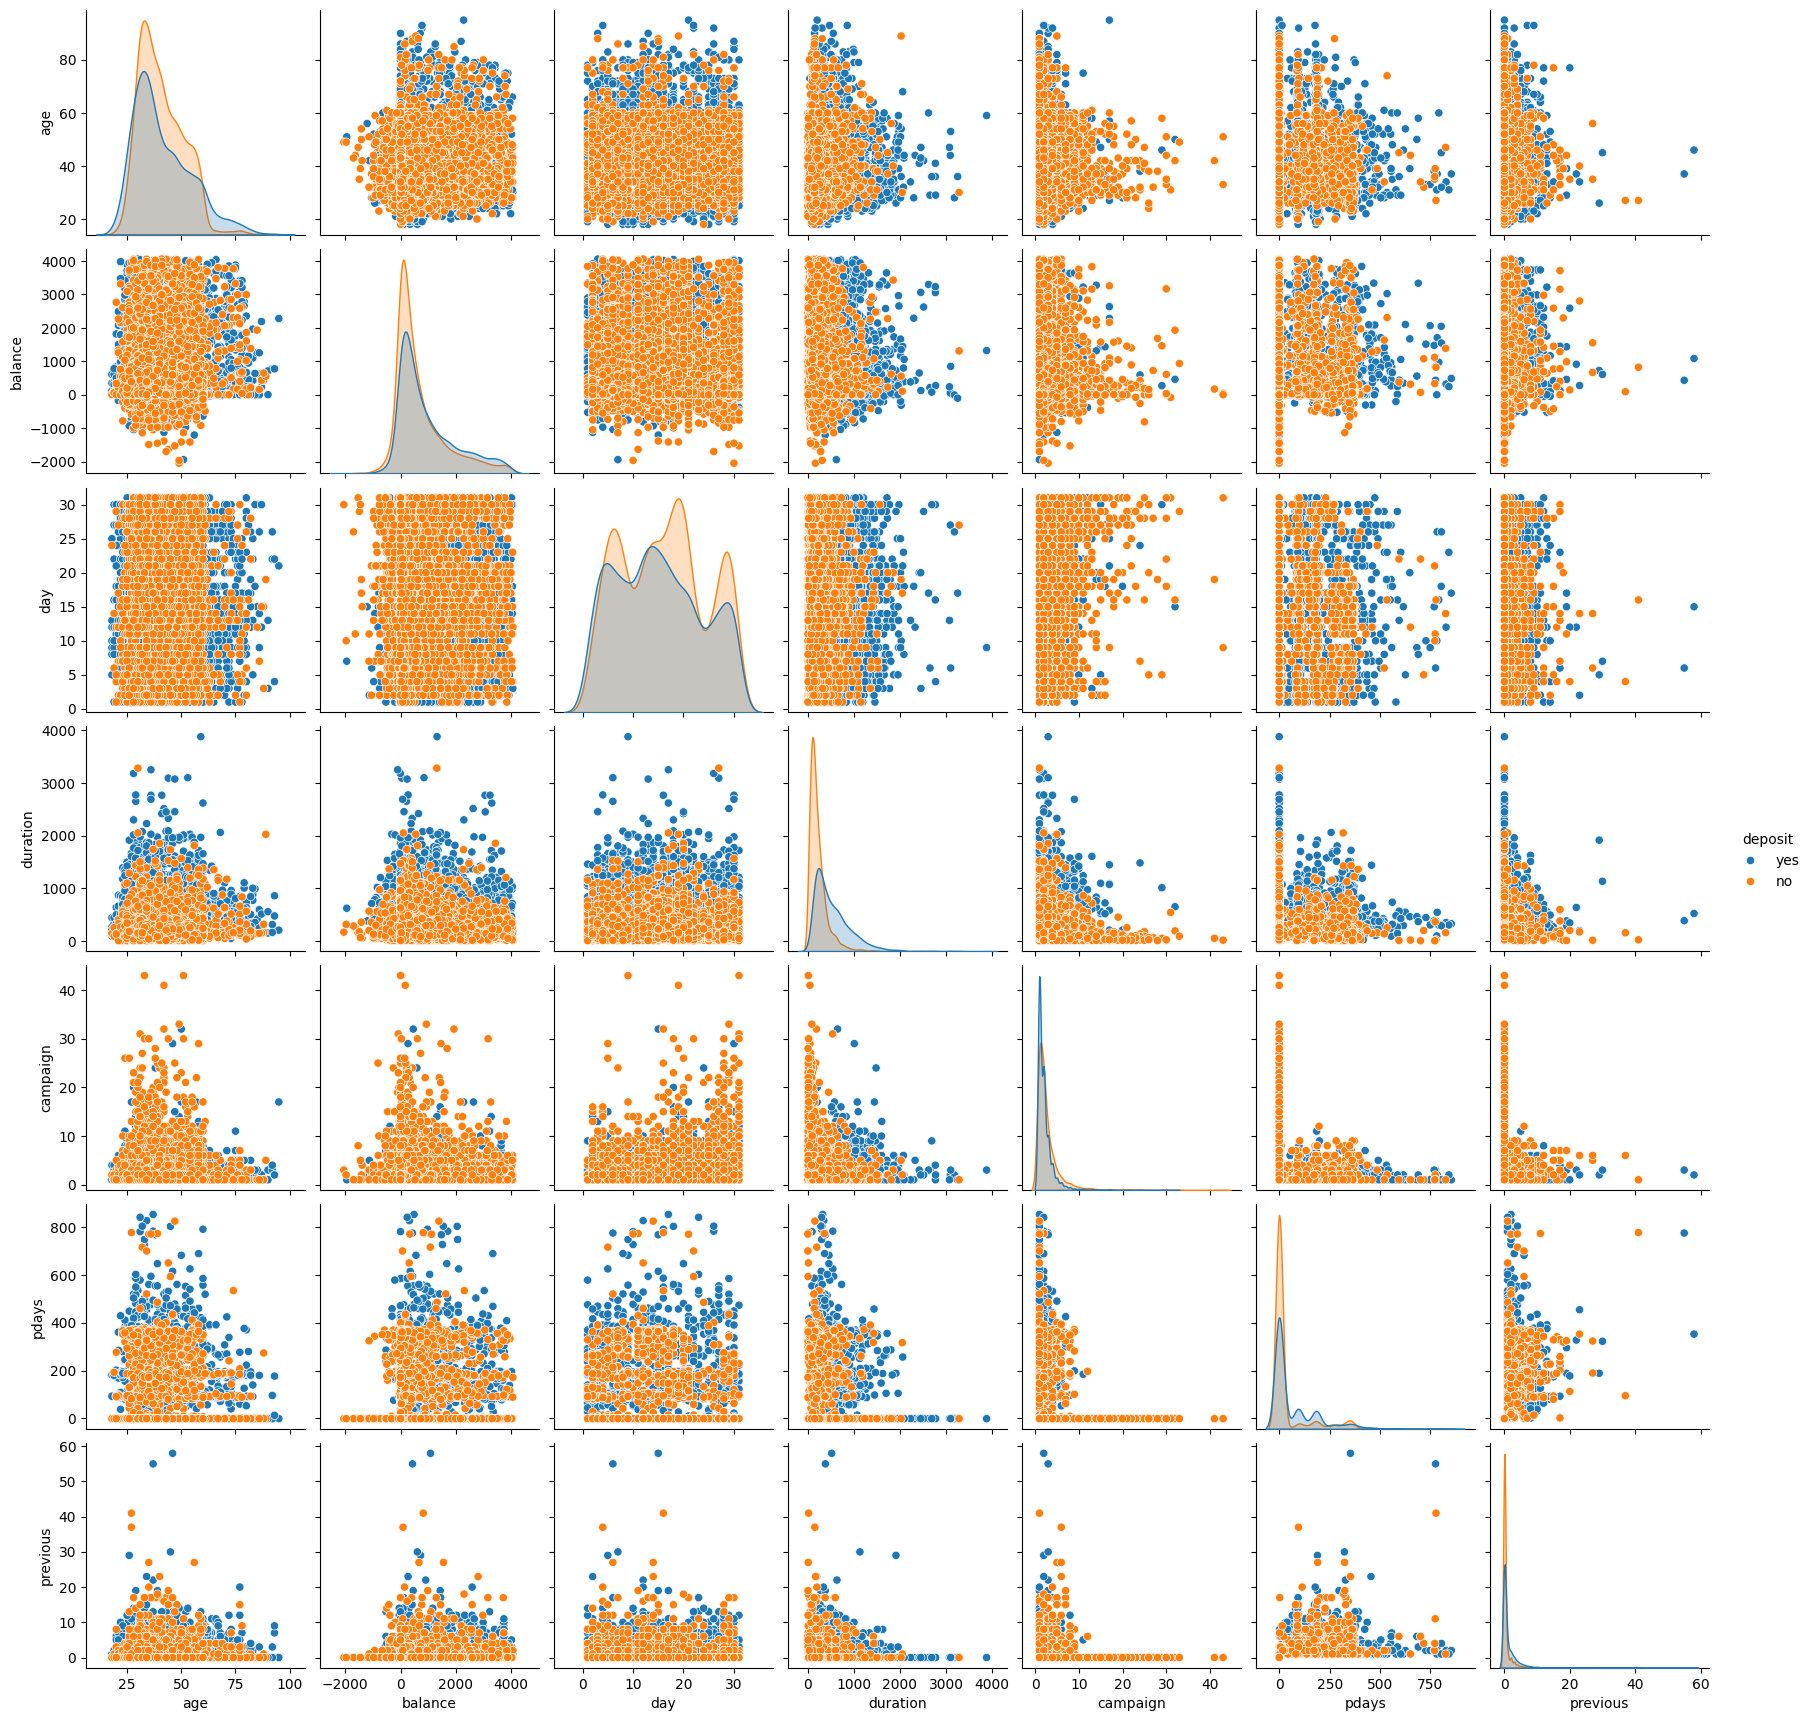

In [400]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
display(df_cleaned.describe())
print(f'максимальный возраст клиента банка {df_cleaned['age'].max()}')
print(f'минимальная продолжительность разговора с клиентом банка {df_cleaned['duration'].min()}')
to_plot = ["age", "balance", "day", "duration", "campaign", "pdays", "previous",'deposit']
# df_cleaned['deposit_bool']=df_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
plt.figure()
sns.pairplot(df_cleaned[to_plot], hue= "deposit")
plt.show()

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Сколько было месяцев, в которых проводилась маркетинговая кампания 12
сфер занятости представлено среди клиентов банка 11


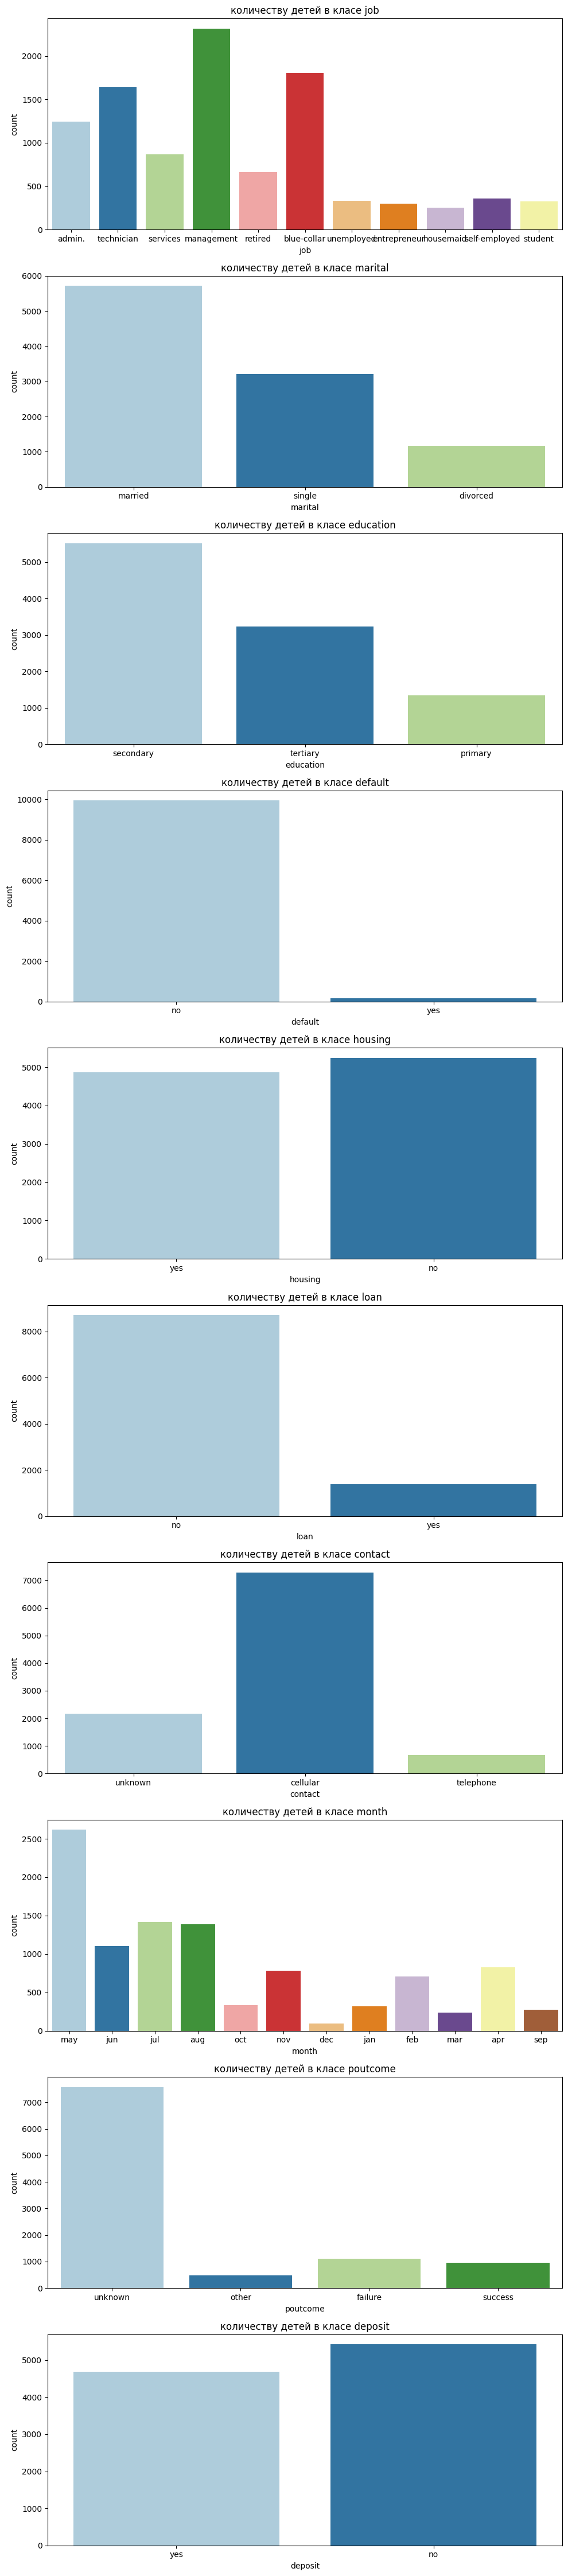

In [401]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

display(df_cleaned.describe(include=['O']))

to_object=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

print(f'Сколько было месяцев, в которых проводилась маркетинговая кампания {df_cleaned['month'].nunique()}')
print(f'сфер занятости представлено среди клиентов банка {df_cleaned['job'].nunique()}')

n=len(to_object)
pal=sns.color_palette("Paired")
fig, axes = plt.subplots(n, figsize=(10, 45)) #фигура+n*2 координатных плоскостей
# #Создаём цикл для всех признаков из списка категориальных признаков
for i in range(n):
    
    pl = sns.countplot(x=df_cleaned[to_object[i]], palette=pal, ax=axes[i]).set_title(f"количеству детей в класе {to_object[i]}")
       
plt.tight_layout() #выравнивание графиков


### Задание 6

### Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).
    + unknown(неизвестно) 7570
    + failure(неудач)     1109
    + success(успехов)    945
    + other(других)       481

продолжительность разговора с клиентом банка 'duration'

In [402]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

# df_cleaned.pivot_table( values='campaign',  # Значения с которыми производим операции
#                         index='poutcome',    # название строк и группировка по значению
#                         columns='deposit',   # название столбцов и группировка по значению
#                         aggfunc='count'      # функция по умолчанию mean()
#                         )


temp=df_cleaned.groupby(['deposit','poutcome'])['deposit'].count().unstack()

p_set={}
for i in temp.columns:
    p_set[i]=temp.loc['yes',i]-temp.loc['no',i]

print(f'значение статуса предыдущей кампании, для которой в текущей успехов намного больше "{max(p_set, key=p_set.get)}"')


значение статуса предыдущей кампании, для которой в текущей успехов намного больше "success"


### Задание 7

самый большой процент неудач "may"


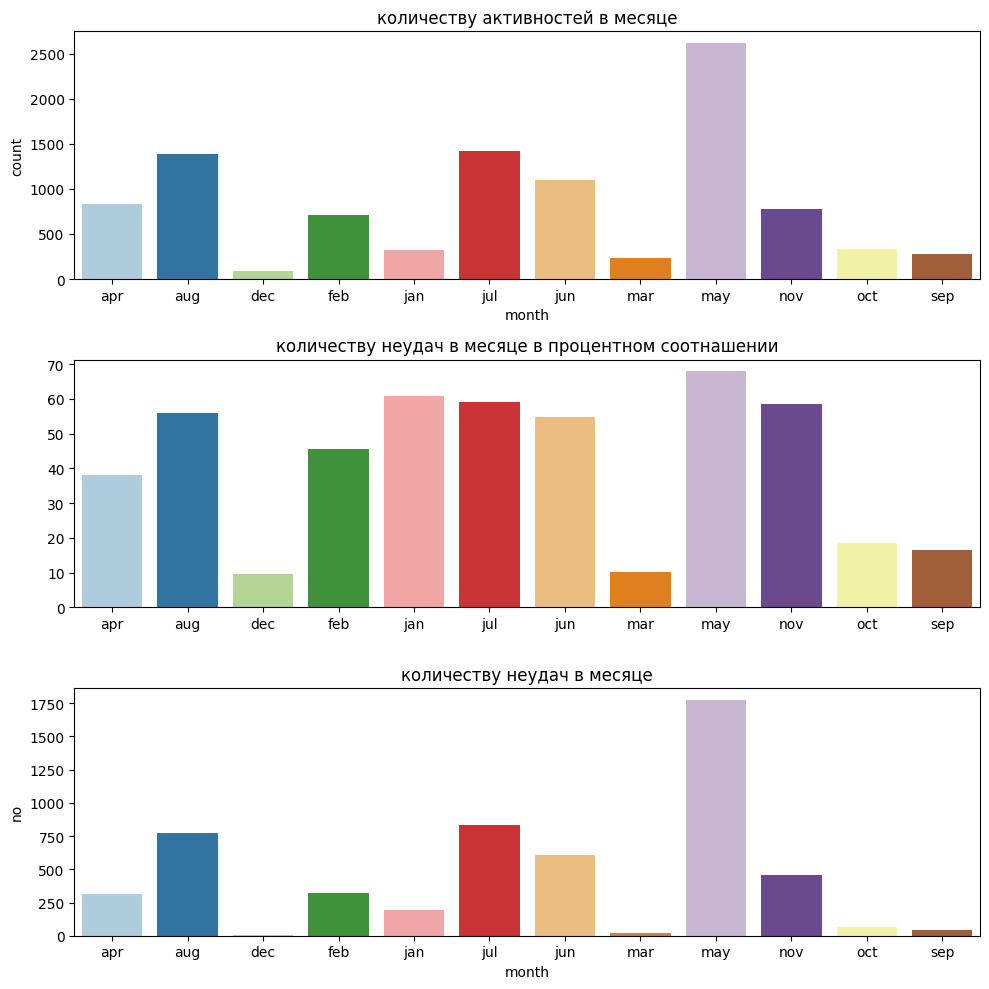

In [403]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

temp=df_cleaned.groupby(['deposit','month'])['deposit'].count().unstack()

n=temp.columns
p_set={}
for i in n:
    p_set[i]=100/(temp.loc['yes',i]+temp.loc['no',i])*temp.loc['no',i]
    
print(f'самый большой процент неудач "{max(p_set, key=p_set.get)}"')

fig, axes = plt.subplots(3, figsize=(10, 10)) #фигура+n*2 координатных плоскостей
# #Создаём цикл для всех признаков из списка категориальных признаков
pl = sns.countplot(x=df_cleaned['month'], palette=pal, order=n, ax=axes[0]).set_title(f"количеству активностей в месяце")
pl = sns.barplot(x=list(p_set.keys()), y=list(p_set.values()), palette=pal, order=n, ax=axes[1]).set_title(f"количеству неудач в месяце в процентном соотнашении")
pl = sns.barplot(x=temp.columns, y=temp.loc['no'], palette=pal, order=n, ax=axes[2]).set_title(f"количеству неудач в месяце")
plt.tight_layout() #выравнивание графиков



### Задание 8

age_group,30-40,40-50,50-60,60+,<30
deposit,,,,,
no,2245,1444,984,157,594
yes,1716,938,670,496,861


<Axes: >

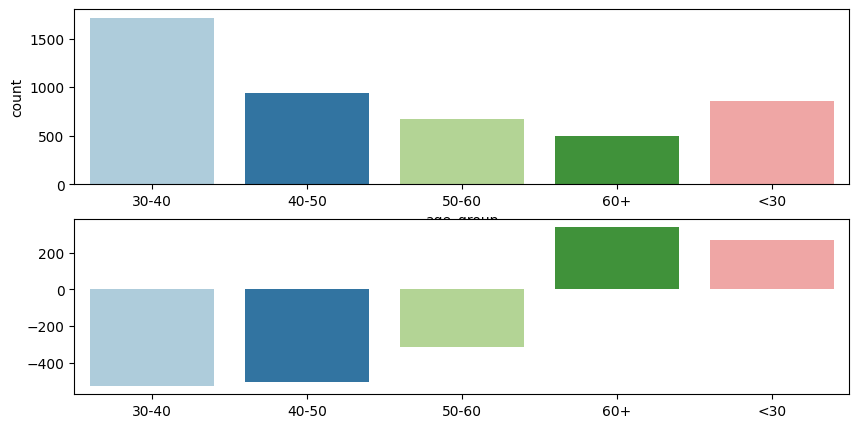

In [404]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

lict_s=['<30', '<30','<30','30-40', '40-50', '50-60', '60+', '60+', '60+', '60+']
# def list_set(x):
#     if x<30 : return '<30'
#     if x>=30 and x<40: return '30-40'
#     if x>=40 and x<50: return '40-50'
#     if x>=50 and x<60: return '50-60'
#     return '60+'

df_cleaned['age_group']=df_cleaned['age'].apply(lambda x: lict_s[x//10])

temp=df_cleaned.groupby(['deposit','age_group'])['deposit'].count().unstack()
display(temp)

n=temp.columns
p_set={}
for i in n:
    p_set[i]=temp.loc['yes',i]-temp.loc['no',i]

fig, axes = plt.subplots(2, figsize=(10, 5))
sns.countplot(x=df_cleaned[df_cleaned['deposit']=='yes']['age_group'], palette=pal, order=n, ax=axes[0])
sns.barplot(x=list(p_set.keys()), y=list(p_set.values()), palette=pal, order=n, ax=axes[1])


# age
# 30-40    3961
# 40-50    2382
# 50-60    1654
# <30      1455
# 60+       653

### Задания 9 и 10

marital,divorced,married,single
deposit,,,
no,624,3303,1497
yes,553,2412,1716


single


<Axes: >

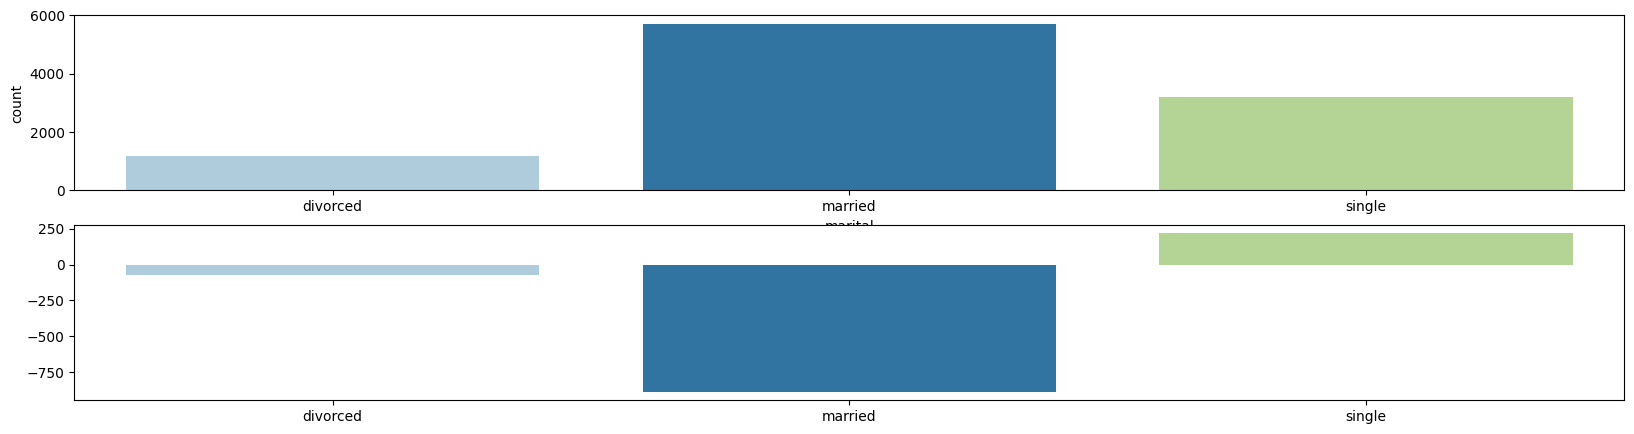

In [405]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

temp=df_cleaned.groupby(['deposit','marital'])['deposit'].count().unstack()
display(temp)

n=temp.columns
p_set={}
for i in n:
    p_set[i]=temp.loc['yes',i]-temp.loc['no',i]

# print(df_cleaned['marital'].value_counts().head(1))
print(max(p_set, key=p_set.get))
fig, axes = plt.subplots(2, figsize=(20, 5))
sns.countplot(x=df_cleaned['marital'], palette=pal, order=n, ax=axes[0])
sns.barplot(x=list(p_set.keys()), y=list(p_set.values()), palette=pal, order=n, ax=axes[1])

education,primary,secondary,tertiary
deposit,,,
no,832,3066,1526
yes,517,2451,1713


education
secondary    5517
Name: count, dtype: int64


<Axes: >

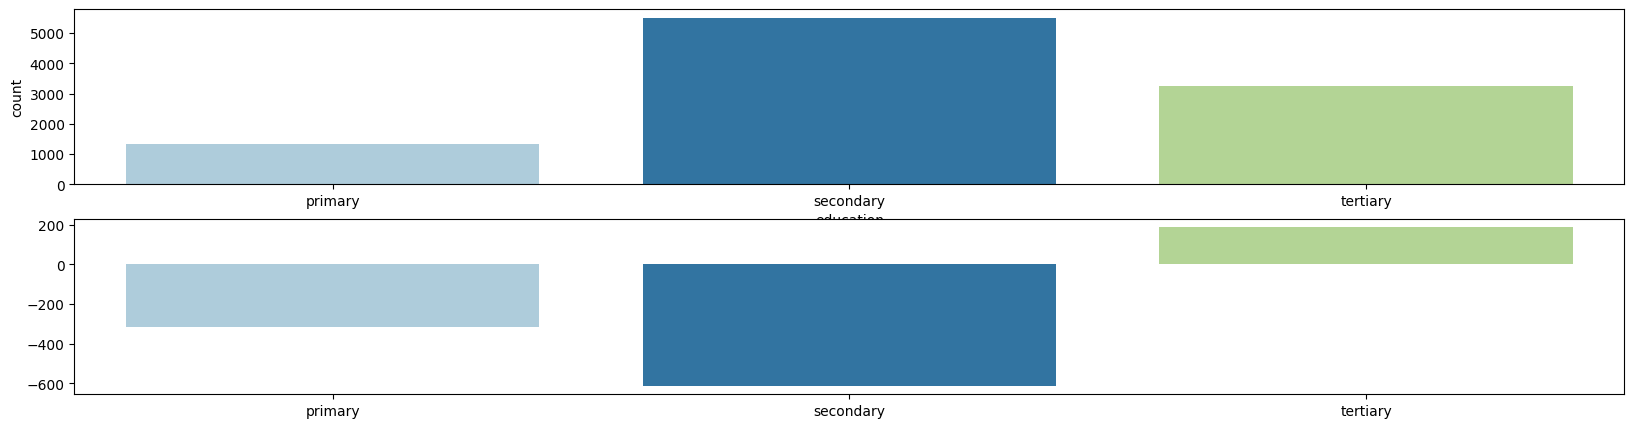

In [406]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

temp=df_cleaned.groupby(['deposit','education'])['deposit'].count().unstack()
display(temp)

n=temp.columns
p_set={}
for i in n:
    p_set[i]=temp.loc['yes',i]-temp.loc['no',i]

print(df_cleaned['education'].value_counts().head(1))
# print(max(p_set, key=p_set.get))
fig, axes = plt.subplots(2, figsize=(20, 5))
sns.countplot(x=df_cleaned['education'], palette=pal, order=n, ax=axes[0])
sns.barplot(x=list(p_set.keys()), y=list(p_set.values()), palette=pal, order=n, ax=axes[1])


job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
deposit,,,,,,,,,,,
no,672,1155,189,153,1180,231,197,523,81,900,143
yes,574,652,111,99,1135,432,161,345,245,738,189


job
management    2315
Name: count, dtype: int64


<Axes: >

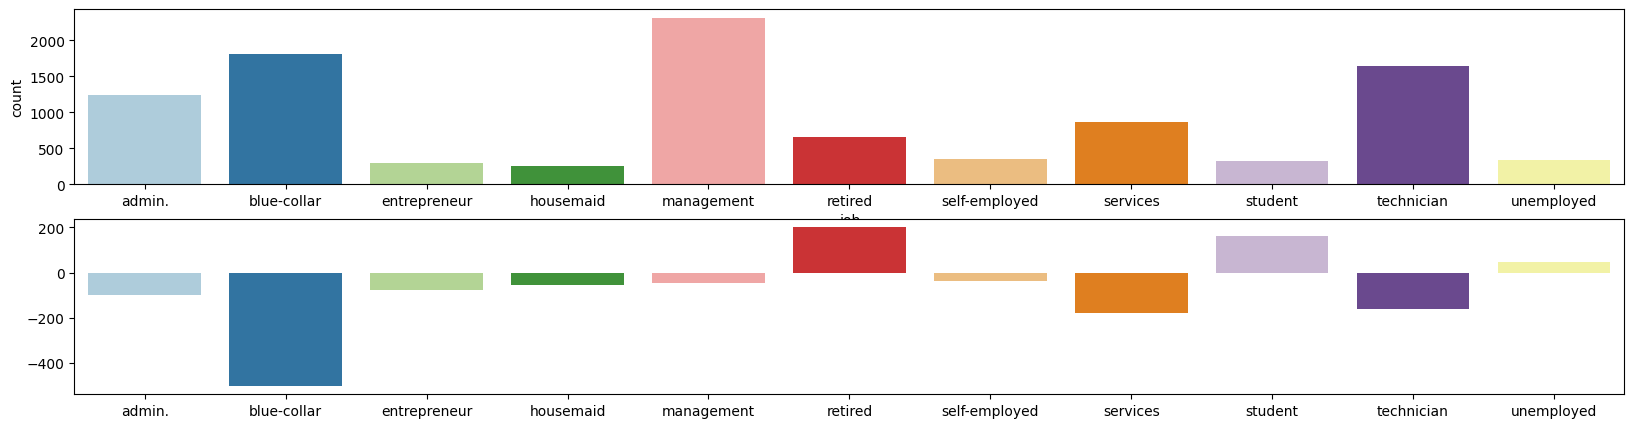

In [407]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

temp=df_cleaned.groupby(['deposit','job'])['deposit'].count().unstack()
display(temp)

n=temp.columns
p_set={}
for i in n:
    p_set[i]=temp.loc['yes',i]-temp.loc['no',i]

print(df_cleaned['job'].value_counts().head(1))
# print(max(p_set, key=p_set.get))
fig, axes = plt.subplots(2, figsize=(20, 5))
sns.countplot(x=df_cleaned['job'], palette=pal, order=n, ax=axes[0])
sns.barplot(x=list(p_set.keys()), y=list(p_set.values()), palette=pal, order=n, ax=axes[1])

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


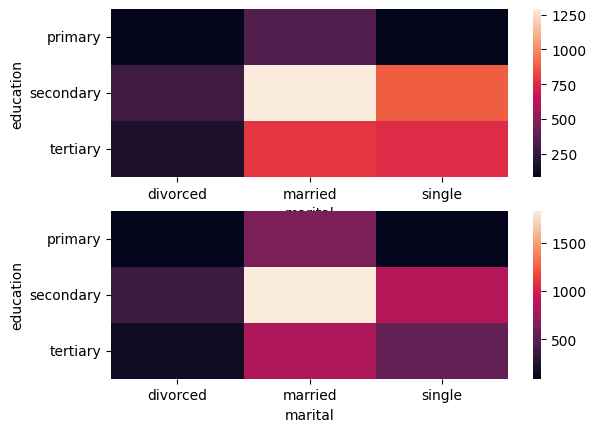

In [408]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

temp=df_cleaned[df_cleaned['deposit']=='yes'].groupby(['education','marital'])['deposit'].count().unstack()
display(temp)


fig, axes = plt.subplots(2)
fig= sns.heatmap(temp, ax=axes[0])

temp=df_cleaned[df_cleaned['deposit']=='no'].groupby(['education','marital'])['deposit'].count().unstack()
display(temp)
fig= sns.heatmap(temp, ax=axes[1])

# n=temp.columns
# p_set={}
# for i in n:
#     p_set[i]=temp.loc['yes',i]-temp.loc['no',i]

# # print(df_cleaned['marital'].value_counts().head(1))
# print(max(p_set, key=p_set.get))
# fig, axes = plt.subplots(2, figsize=(20, 5))
# # sns.countplot(x=df_cleaned['marital'], palette=pal, order=n, ax=axes[0])
# sns.barplot(x=list(p_set.keys()), y=list(p_set.values()), palette=pal, order=n, ax=axes[1])

## Часть 3: преобразование данных

### Задание 1

In [409]:
# преобразуйте уровни образования
label_encoder = LabelEncoder()
df_cleaned['education']=label_encoder.fit_transform(df_cleaned['education'])
(f'сумма получившихся значений для признака education = {df_cleaned['education'].sum()}')

'сумма получившихся значений для признака education = 11995'

In [410]:
label_encoder = LabelEncoder()
df_cleaned['age_group']=label_encoder.fit_transform(df_cleaned['age_group'])
a='-'*20
b='|'+' '*18+'|'
print(a)
for i in range(10):
    print(b)
print(a)

--------------------
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
|                  |
--------------------


### Задания 2 и 3

In [411]:
# преобразуйте бинарные переменные в представление из нулей и единиц
columns_to_change=['default', 'housing', 'loan', 'deposit']
for index in columns_to_change:
    df_cleaned[index]=df_cleaned[index].apply(lambda x: 1 if x=='yes' else 0)
    
print('стандартное отклонение по преобразованной в корректный вид целевой переменной deposit = {:.3f}'.format(df_cleaned['deposit'].std()))
print()
n_sum=round(df_cleaned['default'].mean()+df_cleaned['housing'].mean()+df_cleaned['loan'].mean(),3)
print(f"Сумма среднее арифметическое для получившихся переменных 'default', 'housing', 'loan', {n_sum}")

стандартное отклонение по преобразованной в корректный вид целевой переменной deposit = 0.499

Сумма среднее арифметическое для получившихся переменных 'default', 'housing', 'loan', 0.635


### Задание 4

In [412]:
df_etolon=df_cleaned.copy()

In [ ]:
# создайте дамми-переменные
df_cleaned=df_etolon.copy()
columns_to_change=['job','marital','contact','month','poutcome']

# df_cleaned = pd.get_dummies(df_cleaned)#, columns=columns_to_change)#, drop_first=True)
temp=pd.get_dummies(df_cleaned[columns_to_change])
df_cleaned = pd.concat([df_cleaned, temp], axis=1)

print(f'теперь всего признаков в датасете, не считая целевую переменную: {df_cleaned.shape[1]-1}')
df_cleaned = df_cleaned.drop(columns=columns_to_change)

# ML_6 Lesson_4
# data_c=df_cleaned.copy()
# one_hot_encoder = preprocessing.OneHotEncoder()
#  # учим и создаём новые признаки
# df_onehot = one_hot_encoder.fit_transform(data_c[columns_to_change]).toarray()
# # получаем список с названием новых признаков
# columns = one_hot_encoder.get_feature_names_out(columns_to_change)
# # преобразуем массив в DataFrame с названием колонок новых признаков
# df_onehot_df = pd.DataFrame(df_onehot, columns=columns)
# # удаляем колонку с index
# data_c = data_c.reset_index().drop(['index'], axis = 1) 
# # объединяем DataFrame с новыми признаками и старые данные
# data_c = pd.concat([data_c, df_onehot_df], axis=1) 
# # в общем DataFrame удаляем колонки с признаками которые нужно было кодировать
# # data_c = data_c.drop(columns=columns_to_change)

# df_filtered.columns

теперь всего признаков в датасете, не считая целевую переменную: 50


### Задания 5 и 6

In [414]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df_cleaned, 10)

contact_cellular  contact_unknown     0.837885
pdays             poutcome_unknown    0.824031
marital_married   marital_single      0.779038
previous          poutcome_unknown    0.628346
pdays             poutcome_failure    0.608719
poutcome_failure  poutcome_unknown    0.606736
poutcome_success  poutcome_unknown    0.555044
age               job_retired         0.545524
education         job_management      0.518735
pdays             previous            0.513708
dtype: float64

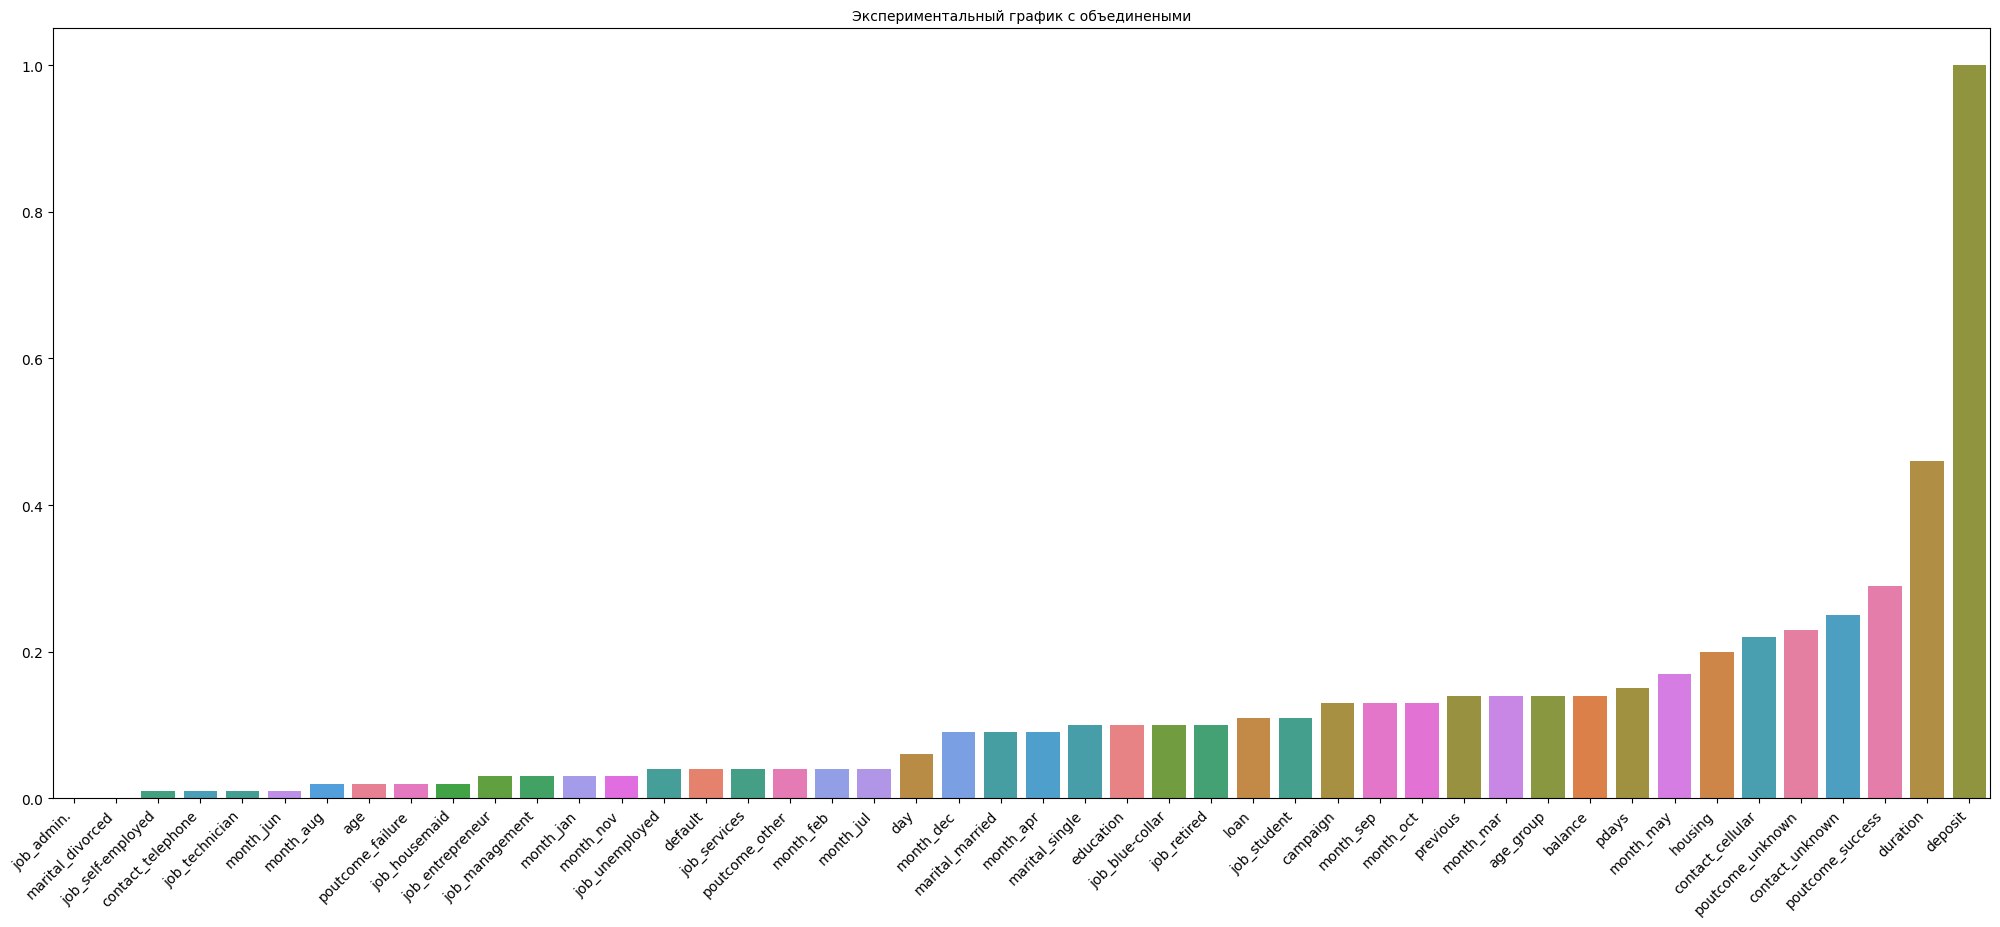

In [415]:
temp=df_cleaned.corr(numeric_only=True).abs().round(2)
plt.figure(figsize=(25,10))  
sns.barplot(temp.loc[['deposit'],::], order=temp['deposit'].sort_values().index   
            ).set_title('Экспериментальный график с объединеными', fontsize=10);  
plt.xticks(rotation=45, 
           ha='right');   

<Axes: >

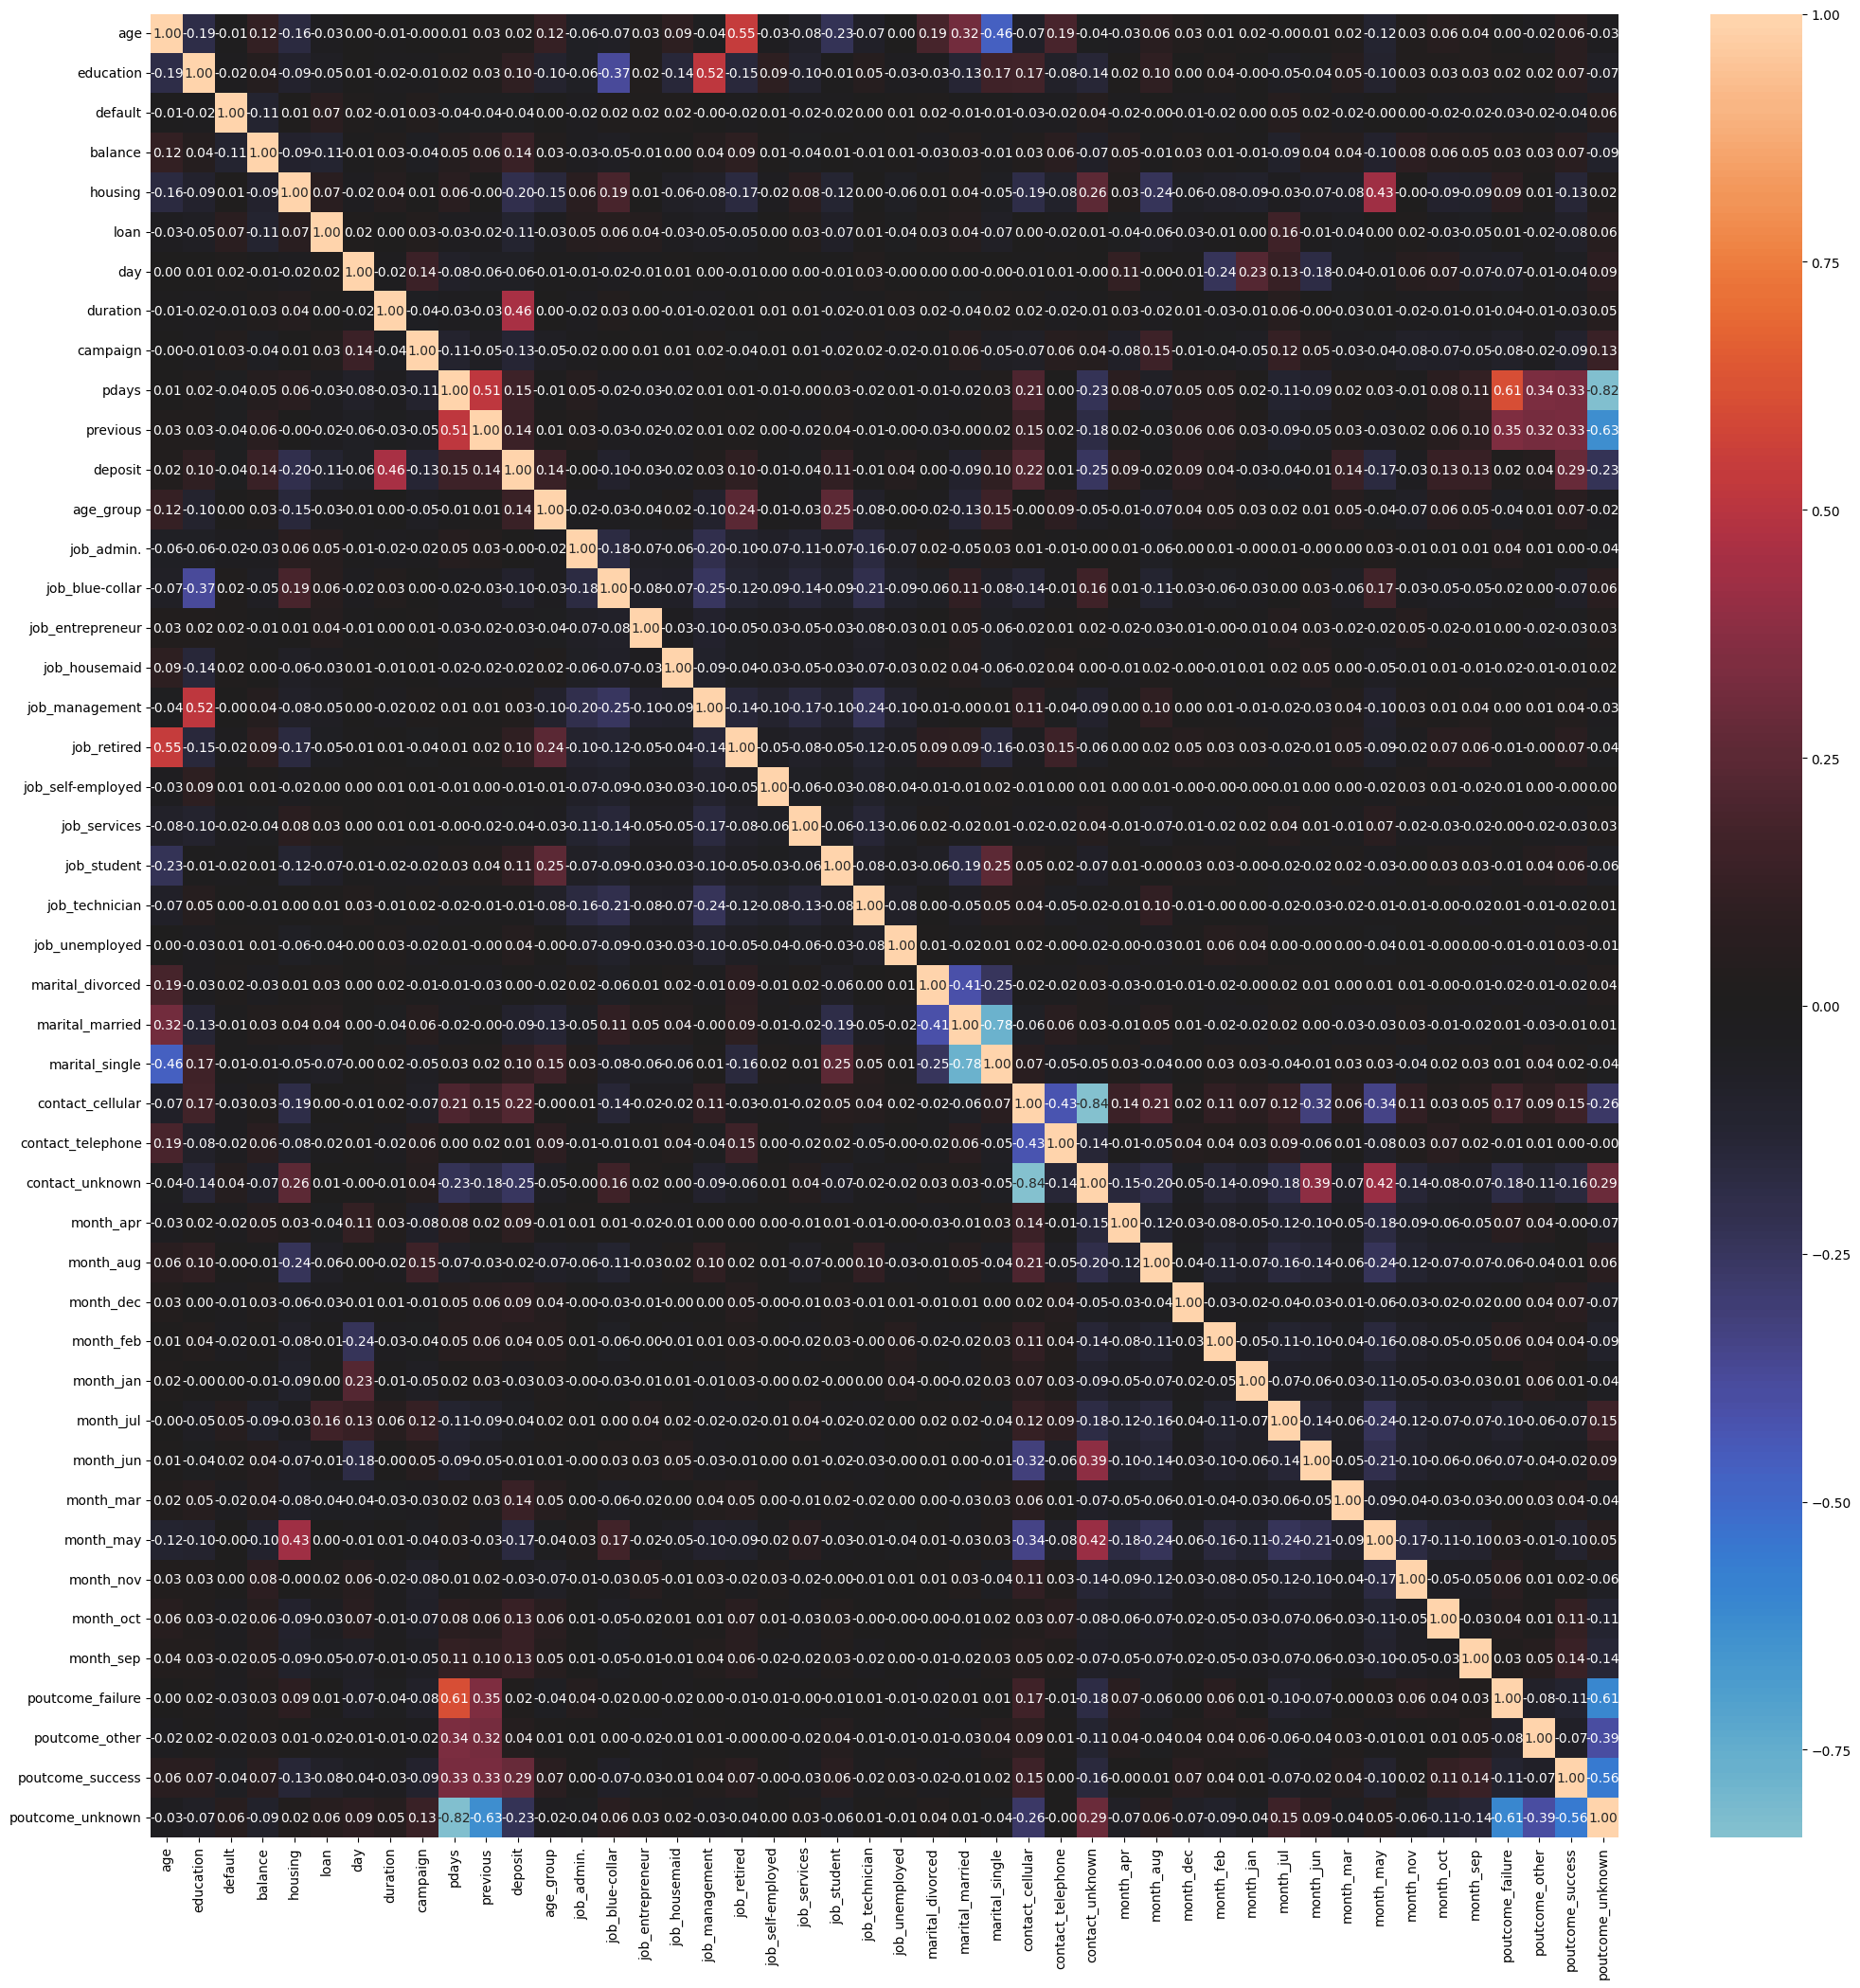

In [416]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

plt.figure(figsize=(25,25))  
sns.heatmap(df_cleaned.corr(numeric_only=True),fmt='.2f',annot=True, center=0)

### Задания 7 и 8

In [417]:
X = df_cleaned.drop(['deposit'], axis=1)
y = df_cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [418]:
# рассчитайте необходимые показатели

print(f'размер тестовой выборки {X_test.shape[0]}')
print()
print('среднее значение целевой переменной на тестовой выборке {:.2f}'.format(y_test.mean()))


размер тестовой выборки 3335

среднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [419]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
skb=SelectKBest(score_func = f_classif, k=15)
x_train_new=skb.fit_transform(X_train, y_train)        # x=skb.fit_transform(X_train, y_train)
# x_test_new=skb.transform(X_test)
print('15 признаков наилучшим образом подходящих для использования в задаче:')
lable_n=' '*70+'+ '
lable_name= skb.get_feature_names_out()
for name in  lable_name:
    print(lable_n+name)
    
X_train=X_train[lable_name]
X_test=X_test[lable_name]

15 признаков наилучшим образом подходящих для использования в задаче:
                                                                      + balance
                                                                      + housing
                                                                      + duration
                                                                      + campaign
                                                                      + pdays
                                                                      + previous
                                                                      + age_group
                                                                      + contact_cellular
                                                                      + contact_unknown
                                                                      + month_mar
                                                                      + month_may
                          

### Задание 10

In [479]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
display(scaler)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=lable_name)
X_test_scaled = scaler.transform(X_test)
print('среднее арифметическое для первого предиктора из тестовой выборки {:.2f}'.format(X_test_scaled[:, 0].mean()))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=lable_name)
print('среднее арифметическое для первого предиктора из тестовой выборки {:.2f}'.format(X_test_scaled['balance'].mean()))


MinMaxScaler()

среднее арифметическое для первого предиктора из тестовой выборки 0.47
среднее арифметическое для первого предиктора из тестовой выборки 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [480]:
# обучите логистическую регрессию и рассчитайте метрики качества

Logi_Rig=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
Logi_Rig.fit(X_train_scaled, y_train)
y_pred_test=Logi_Rig.predict(X_test_scaled)

print('Accuracy: {:.2f} Версии библиотеки постоянно меняются по этому +0,01'.format(metrics.accuracy_score(y_pred_test, y_test))) # Версии библиотеки постоянно меняю по этому +0,01
print(metrics.classification_report(y_pred_test, y_test))

Accuracy: 0.80 Версии библиотеки постоянно меняются по этому +0,01
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1961
           1       0.73      0.83      0.78      1374

    accuracy                           0.80      3335
   macro avg       0.80      0.81      0.80      3335
weighted avg       0.81      0.80      0.81      3335



### Задания 2,3,4

In [481]:
# обучите решающие деревья, настройте максимальную глубину

dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)
y_pred_train=dt_clf.predict(X_train_scaled)
y_pred_test=dt_clf.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_pred_test, y_test)))
print(metrics.classification_report(y_pred_train, y_train))
print(metrics.classification_report(y_pred_test, y_test))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1847
           1       0.71      0.74      0.72      1488

    accuracy                           0.75      3335
   macro avg       0.74      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [484]:
for n in range(1,21):
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy', 
        max_depth=n,
        random_state=42
    )
    #Обучаем дерево решений по алгоритму CART
    dt_clf.fit(X_train_scaled, y_train)
    y_pred_train=dt_clf.predict(X_train_scaled)
    y_pred_test=dt_clf.predict(X_test_scaled)
    print(n)
    print('Accuracy train: {:.2f}'.format(metrics.accuracy_score(y_pred_train, y_train)))
    print('Accuracy test:  {:.2f}'.format(metrics.accuracy_score(y_pred_test, y_test)))
    print()

# print(metrics.classification_report(y_pred_train, y_train))
# print(metrics.classification_report(y_pred_test, y_test))

1
Accuracy train: 0.71
Accuracy test:  0.71

2
Accuracy train: 0.73
Accuracy test:  0.72

3
Accuracy train: 0.78
Accuracy test:  0.77

4
Accuracy train: 0.78
Accuracy test:  0.77

5
Accuracy train: 0.80
Accuracy test:  0.79

6
Accuracy train: 0.82
Accuracy test:  0.81

7
Accuracy train: 0.84
Accuracy test:  0.82

8
Accuracy train: 0.84
Accuracy test:  0.81

9
Accuracy train: 0.85
Accuracy test:  0.81

10
Accuracy train: 0.87
Accuracy test:  0.80

11
Accuracy train: 0.88
Accuracy test:  0.79

12
Accuracy train: 0.89
Accuracy test:  0.79

13
Accuracy train: 0.90
Accuracy test:  0.79

14
Accuracy train: 0.91
Accuracy test:  0.78

15
Accuracy train: 0.92
Accuracy test:  0.78

16
Accuracy train: 0.93
Accuracy test:  0.78

17
Accuracy train: 0.94
Accuracy test:  0.78

18
Accuracy train: 0.95
Accuracy test:  0.77

19
Accuracy train: 0.96
Accuracy test:  0.77

20
Accuracy train: 0.97
Accuracy test:  0.76



### Задание 5

In [485]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {
              'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_dt = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'), 
    param_grid=param_grid, 
    cv=5,
    scoring=('f1'),
    n_jobs = -1
)  
%time grid_search_dt.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_dt.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на валидационном наборе: {:.2f}".format(grid_search_dt.score(X_test_scaled, y_test)))

y_valid_pred = grid_search_dt.predict(X_test_scaled)
acc_le=metrics.f1_score(y_test, y_valid_pred)
print('f1_score на валидационном наборе: {:.2f}'.format(acc_le))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_dt.best_params_))

CPU times: total: 188 ms
Wall time: 3.06 s
f1_score на обучающем наборе: 0.82
accuracy на валидационном наборе: 0.81
f1_score на валидационном наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


In [470]:
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth= 7,
    min_samples_split= 10,
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)
y_pred_train=dt_clf.predict(X_train_scaled)
y_pred_test=dt_clf.predict(X_test_scaled)
print('F1: {:.2f}'.format(metrics.f1_score(y_pred_test, y_test)))
print(metrics.classification_report(y_pred_train, y_train))
print(metrics.classification_report(y_pred_test, y_test))

F1: 0.81
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3552
           1       0.84      0.81      0.82      3218

    accuracy                           0.84      6770
   macro avg       0.84      0.83      0.84      6770
weighted avg       0.84      0.84      0.84      6770

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1744
           1       0.82      0.79      0.81      1591

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=100,
    criterion = 'gini',
    max_depth=10,
    min_samples_leaf=5
)

rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_pred_test = rf.predict(X_test_scaled)
print('Accuracy тестового набора: {:.2f}'.format(metrics.accuracy_score(y_pred_test, y_test)))
print('Recall тестового набора: {:.2f}'.format(metrics.recall_score(y_pred_test, y_test)))
print(metrics.classification_report(y_pred_test, y_test))

f1_score на обучающем наборе: 0.85
Accuracy тестового набора: 0.83
Recall тестового набора: 0.83
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1728
           1       0.83      0.80      0.82      1607

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [512]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Создаем объект класса градиентный бустинг
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    random_state=42, 
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_test  = gb.predict(X_test_scaled)

# Оцениваем качество по метрике F1
print(f'f1_score для GradientBoostingRegressor {round(metrics.f1_score(y_pred_test, y_test),2)}')
print(metrics.classification_report(y_pred_test, y_test))

f1_score для GradientBoostingRegressor 0.8
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1730
           1       0.82      0.79      0.80      1605

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 4

В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

In [526]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', linear_model.LogisticRegression()),
    ('dt',  tree.DecisionTreeRegressor(random_state=42)),
    # ('dt_clf', tree.DecisionTreeClassifier(criterion='entropy', max_depth= 7, min_samples_split= 10, random_state=42)),
    # ('gb', ensemble.GradientBoostingClassifier(learning_rate = 0.05, random_state=42, n_estimators=300, max_depth=10, min_samples_leaf=5))
]

# Создаем объект класса стекинг
reg = ensemble.StackingRegressor(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression()
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_test = reg.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(metrics.recall_score(y_test, y_pred_test), 2)}')
print(metrics.classification_report(y_pred_test, y_test))

ValueError: The estimator LogisticRegression should be a regressor.

### Задание 5

In [427]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [428]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna